# Coffea-Casa Benchmark Example 7

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program will graph the sum of Jet pT's which are greater than 30 GeV and farther than a Euclidean distance of 0.4 from any lepton with pT > 10 GeV.
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 200)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]

        muons = events.Muon
        electrons = events.Electron
        jets = events.Jet
        
        output['cutflow']['all events'] += ak.size(jets, axis=0)
        output['cutflow']['all jets'] += ak.sum(ak.num(jets, axis=1))
        
        # Get jets with higher GeV than 30.
        min_jetpt = (jets.pt > 30)
        output['cutflow']['jets with pt > 30'] += ak.sum(ak.sum(min_jetpt, axis=1))
        
        # Get all leptons with higher GeV than 10.
        min_muonpt = (muons.pt > 10)
        output['cutflow']['muons with pt > 10'] += ak.sum(ak.sum(min_muonpt, axis=1))
        min_electronpt = (electrons.pt > 10)
        output['cutflow']['electrons with pt > 10'] += ak.sum(ak.sum(min_electronpt, axis=1))
        
        # Mask jets and leptons with their minimum requirements/
        goodjets = jets[min_jetpt]
        goodmuons = muons[min_muonpt]
        goodelectrons = electrons[min_electronpt]
    
        jet_muon_pairs = ak.cartesian({'jets': goodjets, 'muons': goodmuons}, nested=True)
        jet_electron_pairs = ak.cartesian({'jets': goodjets, 'electrons': goodelectrons}, nested=True)
    
        # This long conditional checks that the jet is at least 0.4 euclidean distance from each lepton. It then checks if each unique jet contains a False, i.e., that a jet is 0.4 euclidean distance from EVERY specific lepton in the event.
        good_jm_pairs = goodjets.nearest(goodmuons).delta_r(goodjets) > 0.4
        good_je_pairs = goodjets.nearest(goodelectrons).delta_r(goodjets) > 0.4
        good_jl_pairs = good_jm_pairs & good_je_pairs
        
        output['cutflow']['jet-muon pairs'] += ak.sum(ak.sum(good_jm_pairs, axis=1))
        output['cutflow']['jet-electron pairs'] += ak.sum(ak.sum(good_je_pairs, axis=1))
        output['cutflow']['jet-lepton pairs'] += ak.sum(ak.sum(good_jl_pairs, axis=1))
        
        # We then mask our jets with all three of the above good pairs to get only jets that are 0.4 distance from every type of lepton, and sum them.
        sumjets = ak.sum(goodjets[good_jl_pairs].pt, axis=1)
        output['cutflow']['final jets'] += ak.sum(ak.num(goodjets[good_jl_pairs], axis=1))
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=sumjets)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 5883292967,
 'columns': {'Electron_eta',
  'Electron_phi',
  'Electron_pt',
  'Jet_eta',
  'Jet_phi',
  'Jet_pt',
  'Muon_eta',
  'Muon_phi',
  'Muon_pt',
  'nElectron',
  'nJet',
  'nMuon'},
 'entries': 53446198,
 'processtime': 2813.9648463726044,
 'chunks': 534}

<AxesSubplot:xlabel='Jet_pt [GeV]', ylabel='Counts'>

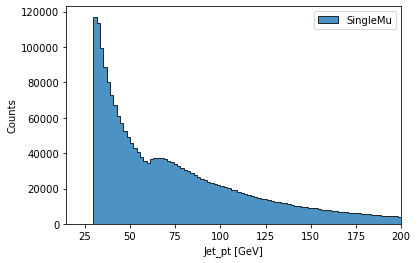

In [5]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all jets 170952895
jets with pt > 30 37461601
muons with pt > 10 58440651
electrons with pt > 10 5483772
jet-muon pairs 27423877
jet-electron pairs 4918297
jet-lepton pairs 3430495
final jets 32545926
